<a href="https://colab.research.google.com/github/RioSatriatama/Prediksi-Harga-BTC/blob/main/Prediksi_Harga_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Fransiskus Xaverius Prasetyo Satriatama (Rio)

Email : riosatriatama0801@gmail.com

LinkedIn : Fransiskus Xaverius Prasetyo Satriatama (https://www.linkedin.com/in/fransiskus-xaverius-prasetyo-satriatama-s-kom-4b16b51bb/)

Github : https://github.com/RioSatriatama

# Studi Kasus: Prediks Harga BTC dengan Algoritma LSTM

# Penjelasan Tentang Algoritma LSTM

Long Short-Term Memory (LSTM) adalah jenis Recurrent Neural Network (RNN) yang dirancang khusus untuk menangani masalah ketergantungan jangka panjang (long-term dependencies) dalam data sekuensial.

LSTM memiliki mekanisme "gate" (forget gate, input gate, output gate) yang memungkinkan untuk mengingat atau melupakan informasi dari langkah-langkah sebelumnya.
Ini membuat LSTM sangat efektif dalam memprediksi data deret waktu seperti harga saham, harga cryptocurrency, dll.

# Langkah-langkah kode:

1. Instal library yfinance jika belum ada.
2. Impor library yang diperlukan.
3. Unduh data historis BTC-USD.
4. Pra-pemrosesan data (menangani missing values, memilih kolom, dll.)
5. Buat fitur tambahan (jika diperlukan) atau gunakan hanya harga penutupan.
6. Normalisasi data (menggunakan MinMaxScaler).
7. Siapkan dataset: buat window data untuk time series (X: data sebelumnya, y: harga berikutnya)
8. Bagi data menjadi training dan testing set.
9. Bentuk ulang data untuk input LSTM (bentuk [samples, time steps, features]).
10. Bangun model LSTM.
11. Kompilasi dan latih model.
12. Buat prediksi dan kembalikan ke skala asli.
13. Evaluasi model (misal dengan RMSE, MAE) dan visualisasi.

# Instalasi dan Import Library

In [1]:
!pip install yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout # mengimpor beberapa layer dari library TensorFlow Keras.
from tensorflow.keras.optimizers import Adam #  import statement dalam bahasa pemrograman Python, yang digunakan untuk mengimpor optimizer Adam dari library TensorFlow Keras.
from sklearn.metrics import mean_squared_error

# Apa itu Adam?

Adam (Adaptive Moment Estimation) adalah salah satu optimizer yang paling populer digunakan dalam deep learning.

# Pengambilan Data

In [4]:
# Unduh data historis BTC-USD dari Yahoo Finance
data = yf.download('BTC-USD', start='2015-01-01', end='2025-01-01')
data.reset_index(inplace=True)
data.head()

/tmp/ipython-input-4-4227377440.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
1,2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2,2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
3,2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
4,2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800


# Preprocessing Data

In [6]:
# Gunakan hanya kolom 'Close'
df = data[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])

/tmp/ipython-input-6-2698113053.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


# Plot harga historis

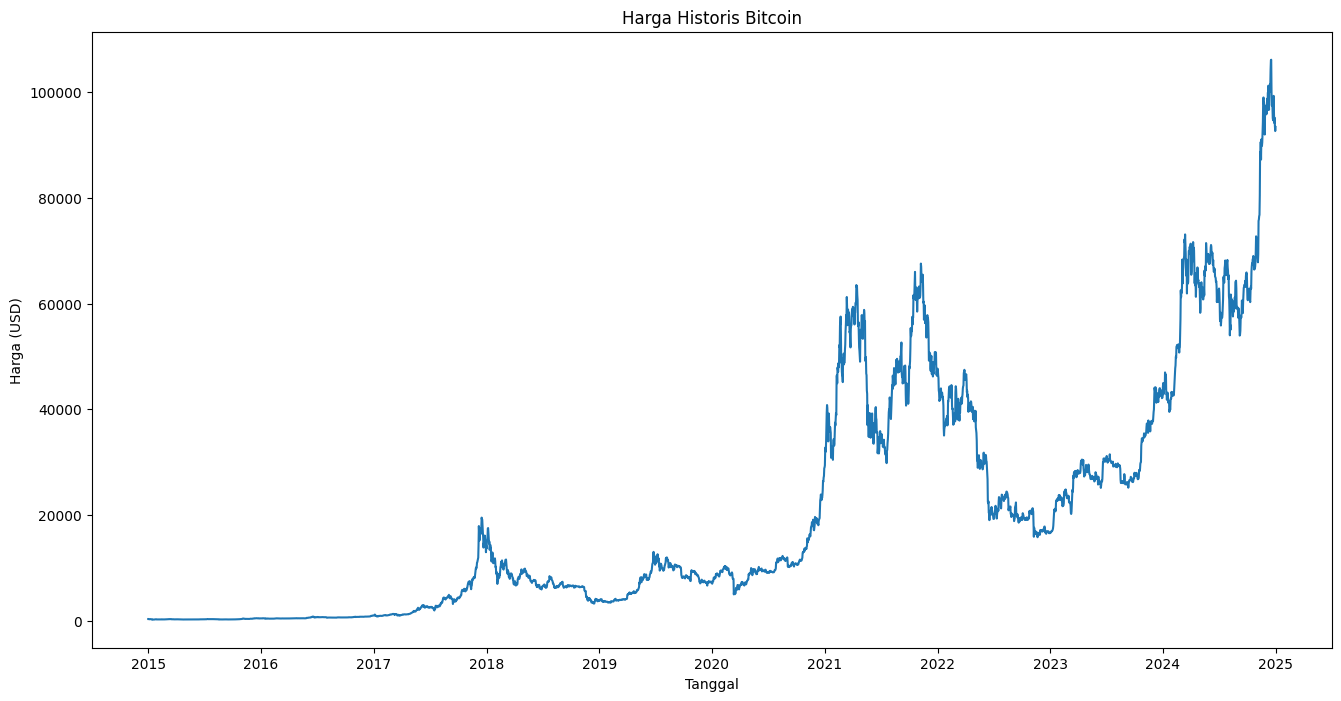

In [7]:
plt.figure(figsize=(16,8))
plt.title('Harga Historis Bitcoin')
plt.plot(df['Date'], df['Close'])
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.show()

# Normalisasi Data

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Persiapan Untuk Datasetnya

In [9]:
# Fungsi untuk membuat dataset
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

# Bagi data (80% training, 20% testing)

In [10]:
training_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[0:training_size]
test_data = scaled_data[training_size:]

# Buat dataset training dan testing

In [11]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

Code tersebut digunakan untuk membagi data menjadi format yang sesuai untuk digunakan dalam model prediksi time series, seperti LSTM. Berikut adalah penjelasan tentang variabel dan fungsi yang digunakan:

1. *time_step = 60*: Variabel `time_step` menentukan jumlah langkah waktu yang digunakan sebagai input untuk memprediksi nilai berikutnya. Dalam kasus ini, `time_step` adalah 60, yang berarti model akan menggunakan 60 nilai sebelumnya untuk memprediksi nilai berikutnya.

2. *create_dataset(train_data, time_step)*: Fungsi `create_dataset` digunakan untuk membagi data menjadi format yang sesuai untuk digunakan dalam model prediksi time series. Fungsi ini membagi data menjadi dua bagian:
- *X_train*: Input data yang digunakan untuk memprediksi nilai berikutnya. Dalam kasus ini, `X_train` akan berisi 60 nilai sebelumnya untuk setiap sampel.
- *y_train*: Nilai target yang ingin diprediksi. Dalam kasus ini, `y_train` akan berisi nilai berikutnya setelah 60 nilai sebelumnya.

3. *X_test, y_test = create_dataset(test_data, time_step)*: Proses yang sama dilakukan untuk data testing (`test_data`) untuk membagi data menjadi input (`X_test`) dan target (`y_test`).

Contoh:
Jika kita memiliki data time series seperti `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]` dan `time_step` adalah 3, maka `create_dataset` akan membagi data menjadi:

- *X_train*: `[[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]`
- *y_train*: `[4, 5, 6, 7, 8, 9]`

Dengan demikian, model dapat mempelajari pola dalam data time series dan memprediksi nilai berikutnya berdasarkan 60 nilai sebelumnya.

# Reshape data untuk LSTM [samples, time steps, features]

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Membangun Model LSTM

In [13]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

# Pelatihan Model

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - loss: 0.0117 - val_loss: 6.8965e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 9.5876e-04 - val_loss: 5.6717e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 8.3086e-04 - val_loss: 5.2249e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - loss: 8.0431e-04 - val_loss: 7.1534e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 7.1030e-04 - val_loss: 5.1372e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 7.4120e-04 - val_loss: 0.0013
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 5.6721e-04 - val_loss: 5.0214e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.0011 - val_loss: 6.4770e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - loss: 6.0566e-04 - val_loss: 4.2639e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 6.7501e-04 - val_loss: 6.3072e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 5.76

# Plot loss

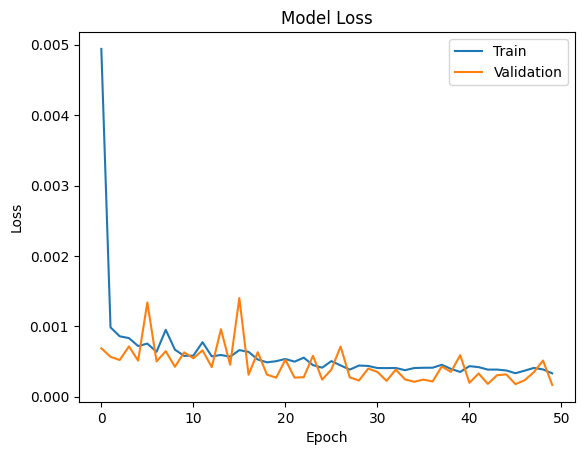

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluasi Model

In [16]:
# Prediksi pada data training dan testing
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [17]:
# Transformasi kembali ke nilai asli
train_predict = scaler.inverse_transform(train_predict)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

In [18]:
# Hitung RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_predict))
print(f'RMSE Training: {train_rmse:.2f}')
print(f'RMSE Testing: {test_rmse:.2f}')

RMSE Training: 1345.56
RMSE Testing: 3775.30


# Visualisasi Prediksi

In [19]:
# Buat plot untuk data training
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict)+time_step, :] = train_predict

In [20]:
# Buat plot untuk data testing
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time_step*2)+1:len(scaled_data)-1, :] = test_predict

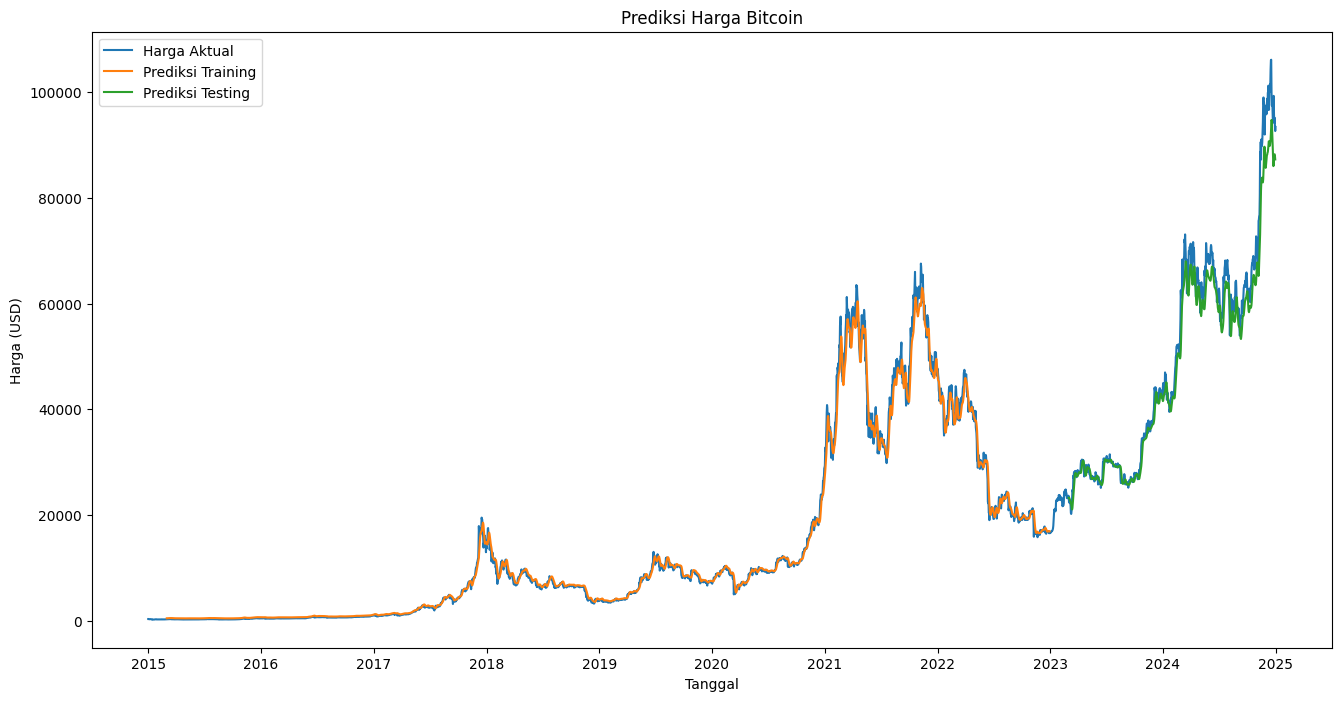

In [21]:
# Plot semua data
plt.figure(figsize=(16,8))
plt.plot(df['Date'], scaler.inverse_transform(scaled_data), label='Harga Aktual')
plt.plot(df['Date'], train_plot, label='Prediksi Training')
plt.plot(df['Date'], test_plot, label='Prediksi Testing')
plt.title('Prediksi Harga Bitcoin')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

# Prediksi Masa Depan

# Prediksi 30 hari ke depan

In [23]:
future_days = 30
x_future = test_data[-time_step:].reshape(1, time_step, 1)

future_predictions = []
for _ in range(future_days):
    pred = model.predict(x_future)
    future_predictions.append(pred[0,0])
    # Reshape the prediction to match the shape of x_future before appending
    x_future = np.append(x_future[:,1:,:], pred.reshape(1, 1, 1), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━

# Transformasi kembali ke nilai asli

In [24]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# Generate tanggal masa depan

In [25]:
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# Plot prediksi masa depan

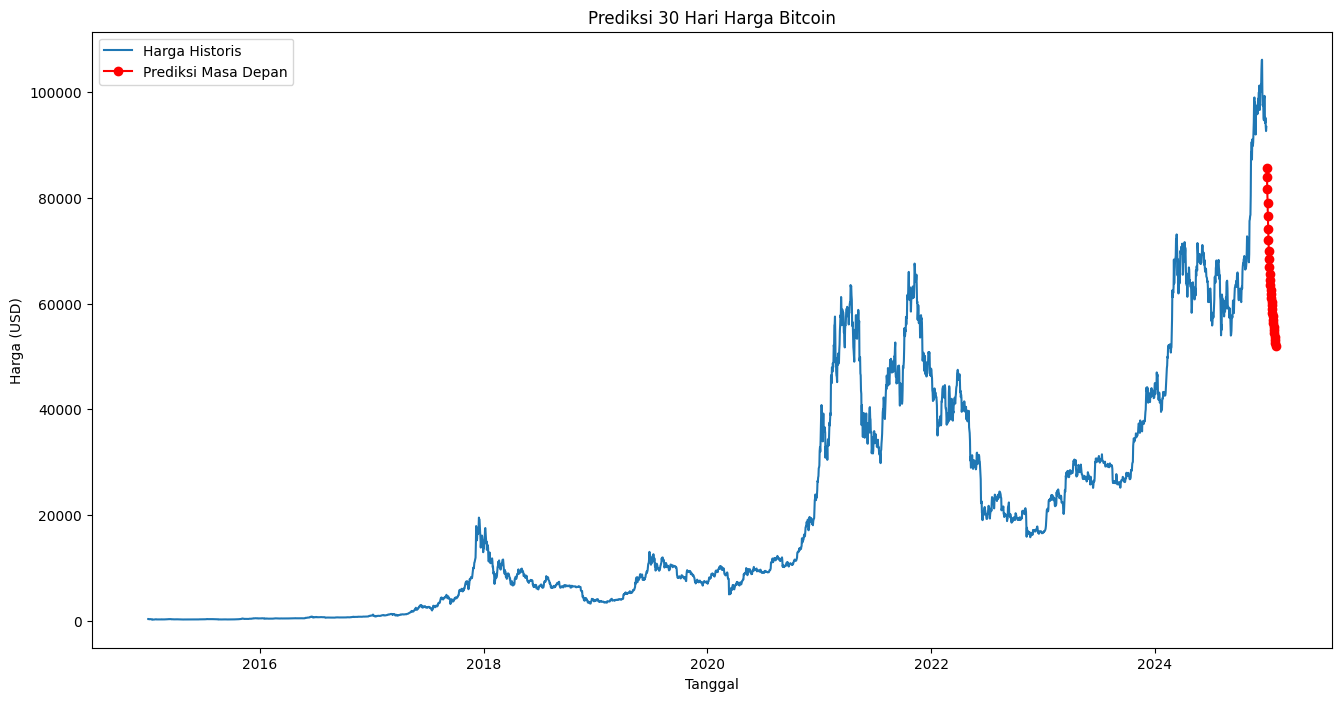

In [26]:
plt.figure(figsize=(16,8))
plt.plot(df['Date'], df['Close'], label='Harga Historis')
plt.plot(future_dates, future_predictions, 'ro-', label='Prediksi Masa Depan')
plt.title('Prediksi 30 Hari Harga Bitcoin')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

Referensi:

- https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html
- https://pythonguides.com/adam-optimizer-pytorch/
- https://spotintelligence.com/2023/03/01/adam-optimizer/
- https://adam.readthedocs.io/en/latest/
- https://www.tensorflow.org/
- https://adam.readthedocs.io/en/latest/installation/pip/